In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [3]:
rs=121
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

In [4]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/stock_hmm_output.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Return','Volatility','HighR','LowR']
target='State'
#train, test = train_test_split(data,test_size=0.2,shuffle=True,random_state=rs,stratify=data['State'])

In [5]:
#With TimeSeries
#First Set Aside Testing data
final_test=[]
l=[]
ft_size=400
for x in data.groupby(['Ticker']):
    final_test.append(x[1][-ft_size:])
    l.append(x[1][:-ft_size])
#Model Training
#model=
#model.fit(x=train_x,y=train_y)
#Model Prediction and Accuracy
#accuracy_score(test_y,model.predict(test_x))


In [6]:
def createSlidingWindow(tr,te,f,t, window=7):
    splitting=SlidingWindowSplitter(window_length=window,step_length=1,fh=[1])
    train_x=[]
    train_y=[]
    test_x=[]
    test_y=[]
    
    for i in splitting.split(tr):
        train_x.append(tr.iloc[i[0]][f].values.flatten())
        train_y.append(tr.iloc[i[1]][t].values.flatten()[0])
    
    for i in splitting.split(te):
        test_x.append(te.iloc[i[0]][f].values.flatten())
        test_y.append(te.iloc[i[1]][t].values.flatten()[0])
    return ((train_x,train_y),(test_x,test_y))

In [6]:
testing_size=500
ns=5
tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)

Skip the two cells below if you have access to the saved training windows

In [ ]:
training_list=[]
testing_list=[]
for i in range(ns):
    training_list.append([[],[]])
    testing_list.append([[],[]])
training_lists = {}
testing_lists = {}
for spread in range(2,25):
    for x in l:
        for (i,t) in enumerate(tss.split(x)):
            ((train_x,train_y),(test_x,test_y))=createSlidingWindow(x.iloc[t[0]],x.iloc[t[1]],features,target, window = spread)
            training_list[i][0] += train_x
            training_list[i][1] += train_y
            testing_list[i][0] += test_x
            testing_list[i][1] += test_y
    training_lists[spread] = training_list
    testing_lists[spread] = testing_list
    training_list=[]
    testing_list=[]
    for i in range(ns):
        training_list.append([[],[]])
        testing_list.append([[],[]])


In [ ]:
with open('saved_training_lists.pkl', 'wb') as f:
    pickle.dump(training_lists, f)

with open('saved_testing_lists.pkl', 'wb') as f:
    pickle.dump(testing_lists, f)

Load training, test windows here. 
They're saved for complexity reasons, RUN CODE from here

In [7]:
with open('saved_training_lists.pkl', 'rb') as f:
    training_lists = pickle.load(f)

with open('saved_testing_lists.pkl', 'rb') as f:
    testing_lists = pickle.load(f)

In [8]:
model = XGBClassifier(tree_method="hist", device="cuda") 
accuracies_xgb = {}
for window in training_lists.keys():
    training_list = training_lists[window]
    testing_list = testing_lists[window]
    a=0 
    for i in range(ns):
        model.fit(X=training_list[i][0],y=training_list[i][1])
        a+= accuracy_score(model.predict(testing_list[i][0]),testing_list[i][1])
    a=a/ns
    accuracies_xgb[window] = a

c:\Users\18585\anaconda3\envs\erdos_spring_2025\Lib\site-packages\xgboost\core.py:729: UserWarning: [02:32:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [9]:
import optuna
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.5, 1.0]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.5, 1.0, 2.0, 5.0]),
        'min_split_loss': trial.suggest_categorical('min_split_loss', [0, 0.1, 0.3, 0.5]),
        "tree_method": "hist",
        "device": "cuda"
    }
    model = XGBClassifier(**param)
    a= 0
    for i in range(ns):
        model.fit(X=training_list[i][0],y=training_list[i][1])
        a+= accuracy_score(model.predict(testing_list[i][0]),testing_list[i][1])
    a=a/ns
    return a

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


[I 2025-04-11 02:34:01,146] A new study created in memory with name: no-name-2ff9d17c-48d8-4199-acf6-73f964cdd437
[I 2025-04-11 02:34:05,312] Trial 0 finished with value: 0.8784513805522209 and parameters: {'max_depth': 3, 'learning_rate': 0.13689826879383785, 'n_estimators': 278, 'subsample': 0.8245477738817034, 'colsample_bytree': 0.9465905625456354, 'reg_alpha': 0.5, 'reg_lambda': 2.0, 'min_split_loss': 0.3}. Best is trial 0 with value: 0.8784513805522209.
[I 2025-04-11 02:34:19,730] Trial 1 finished with value: 0.8735894357743097 and parameters: {'max_depth': 9, 'learning_rate': 0.14801825430570315, 'n_estimators': 158, 'subsample': 0.5568227689416041, 'colsample_bytree': 0.6424197577797028, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'min_split_loss': 0.3}. Best is trial 0 with value: 0.8784513805522209.
[I 2025-04-11 02:34:25,854] Trial 2 finished with value: 0.8769507803121248 and parameters: {'max_depth': 7, 'learning_rate': 0.13630288579684957, 'n_estimators': 114, 'subsample': 0.892

In [10]:
best_params = study.best_params
best_XGB = XGBClassifier(**best_params, tree_method="hist", device="cuda")

In [11]:
def accuracies_model(model):
    accuracies = {}
    for window in training_lists.keys():
        training_list = training_lists[window]
        testing_list = testing_lists[window]
        a=0 
        for i in range(ns):
            model.fit(X=training_list[i][0],y=training_list[i][1])
            a+= accuracy_score(model.predict(testing_list[i][0]),testing_list[i][1])
        a=a/ns
        accuracies[window] = a
    return accuracies

In [12]:
def plot_accuracies(accuracies, model_type):
    plt.figure(figsize=(6, 4))
    plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o')
    plt.title(f"{model_type} accuracy scores")
    plt.xlabel("Window size")
    plt.ylabel("accuracy")
    plt.tight_layout()
    plt.show()

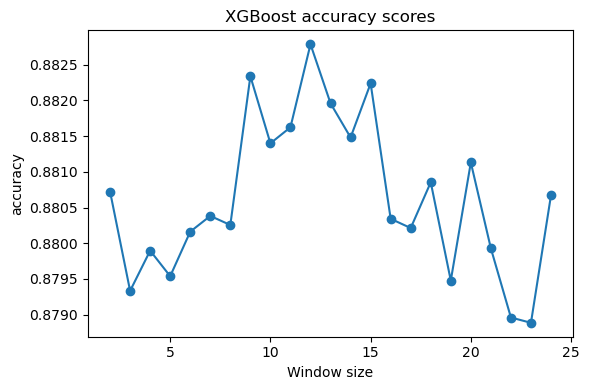

In [13]:
accuracies_xgb = accuracies_model(best_XGB)
plot_accuracies(accuracies_xgb, "XGBoost")

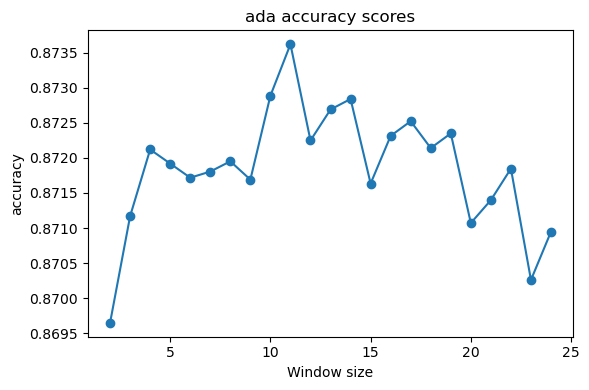

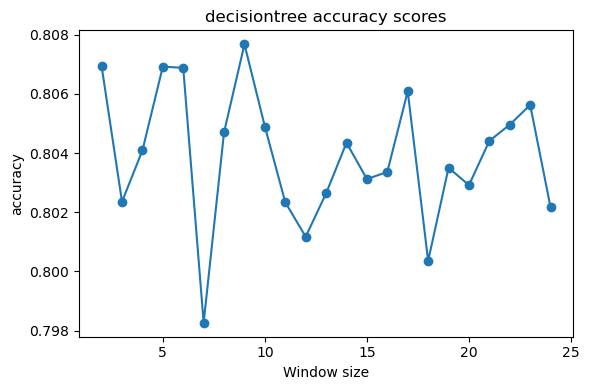

In [14]:
model_names=['ada','decisiontree']
models=[AdaBoostClassifier(n_estimators=100,random_state=121),DecisionTreeClassifier(random_state=rs)]
#Add Possible AdaBoostModels:
for ind, m in enumerate(models):
    acc_model = accuracies_model(m)
    plot_accuracies(acc_model, model_names[ind]) 

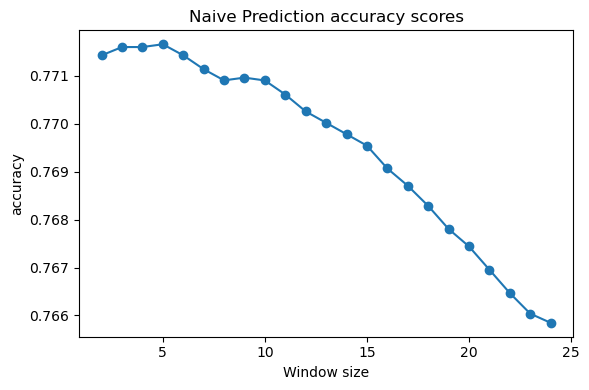

In [16]:
#Naive Prediction
accuracies = {}
for window in training_lists.keys():
    training_list = training_lists[window]
    testing_list = testing_lists[window]
    a=0 
    for i in range(ns):
        a+= accuracy_score([1]*len(testing_list[i][1]),testing_list[i][1])
    a=a/ns
    accuracies[window] = a
plot_accuracies(accuracies, "Naive Prediction")

In [17]:
model = RandomForestClassifier(
    n_estimators = 100, # number of trees in ensemble
    max_depth = 10, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 5, # default is round(sqrt(num_features)), which in this case is 1.
    random_state = 121 # for consistency
    )
accuracies_rfc = {}
for window in training_lists.keys():
    training_list = training_lists[window]
    testing_list = testing_lists[window]
    a=0 
    for i in range(ns):
        model.fit(X=training_list[i][0],y=training_list[i][1])
        a+= accuracy_score(model.predict(testing_list[i][0]),testing_list[i][1])
    a=a/ns
    accuracies_rfc[window] = a

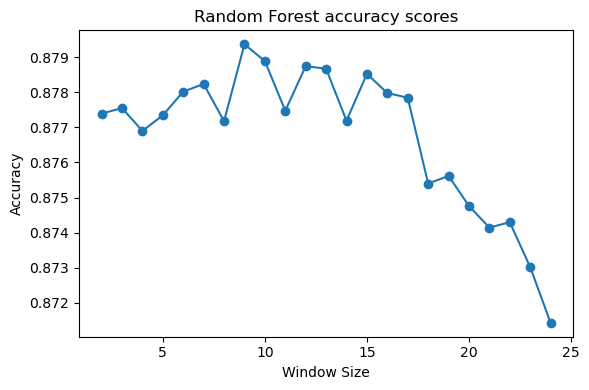

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(list(accuracies_rfc.keys()), list(accuracies_rfc.values()), marker='o')
plt.title("Random Forest accuracy scores")
plt.xlabel("Window Size")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()